Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [1]:
! pip install datasets
! pip install transformers

     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 47.1 MB/s 
     |████████████████████████████████| 1.1 MB 43.8 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 134 kB 35.8 MB/s 
     |████████████████████████████████| 127 kB 47.1 MB/s 
     |████████████████████████████████| 144 kB 20.6 MB/s 
     |████████████████████████████████| 271 kB 38.8 MB/s 
     |████████████████████████████████| 94 kB 446 kB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 5.2 MB/s 


For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [2]:
from datasets import load_dataset

In [3]:
try:
  dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case
except:
  !rm -rf /root/.cache/huggingface
  dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Fine-tuning the model** (20 points)

In [4]:
from transformers import (ElectraTokenizerFast, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [5]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [6]:
tokenizer = ElectraTokenizerFast.from_pretrained(TOKENIZER_NAME)
model_mlm = ElectraForMaskedLM.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Checking content of train dataset

In [7]:
print(f"{len(dataset['train'])} train samples, {len(dataset['test'])} test samples")
dataset['train'][0]

1400000 train samples, 60000 test samples


{'best_answer': 'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.',
 'id': 0,
 'question_content': 'or even on some surfaces?',
 'question_title': "why doesn't an optical mouse work on a glass table?",
 'topic': 4}

In [8]:
dataset['train'] = dataset['train'].select(range(10_000))
dataset['test'] = dataset['test'].select(range(1_000))

Pretrained Electra model in Masked Language Modeling task

In [9]:
def predict_mask(tokenizer, model, sentences):
  for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors='pt')

    with torch.no_grad():
        logits = model(**inputs).logits
    
    mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
    predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)
    predicted_token = tokenizer.decode(predicted_token_id)
    print(f"Original sentence: '{sentence}'")
    print(f"Sentence with predicted word: '{sentence.replace('MASK', predicted_token)}'\n")

In [10]:
pretrain_test_sentences = ["Why don't you ask [MASK]?", "What is [MASK]?", "Let's talk about [MASK] physics"]

predict_mask(tokenizer, model_mlm, pretrain_test_sentences)

Original sentence: 'Why don't you ask [MASK]?'
Sentence with predicted word: 'Why don't you ask [me]?'

Original sentence: 'What is [MASK]?'
Sentence with predicted word: 'What is [it]?'

Original sentence: 'Let's talk about [MASK] physics'
Sentence with predicted word: 'Let's talk about [quantum] physics'



In [11]:
print(dataset['test'][0]['best_answer'], '\n')
predict_mask(tokenizer, model_mlm, [dataset['test'][0]['best_answer'].replace('mind', '[MASK]')])

good communication is what does it.  Can you move beyond small talk and say what's really on your mind.  If you start doing this, my expereince is that potentially good friends will respond or shun you.  Then you know who the really good friends are. 

Original sentence: 'good communication is what does it.  Can you move beyond small talk and say what's really on your [MASK].  If you start doing this, my expereince is that potentially good friends will respond or shun you.  Then you know who the really good friends are.'
Sentence with predicted word: 'good communication is what does it.  Can you move beyond small talk and say what's really on your [mind].  If you start doing this, my expereince is that potentially good friends will respond or shun you.  Then you know who the really good friends are.'



In [12]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

def prepare_dataset(dataset, BATCH_SIZE=16, SEED=42, shuffle_train=True):
    tokenized_datasets = dataset.map(tokenize_function, batched=True, batch_size=BATCH_SIZE)
    tokenized_datasets = tokenized_datasets.remove_columns(['id', 'question_title', 'question_content', 'best_answer'])
    tokenized_datasets.set_format("torch")

    small_train_dataset = tokenized_datasets["train"].shuffle(seed=SEED).select(range(10_000))
    small_test_dataset = tokenized_datasets["test"].shuffle(seed=SEED).select(range(1_000))

    train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(small_test_dataset, batch_size=BATCH_SIZE)
    
    return train_dataloader, test_dataloader

In [13]:
train_dataloader, test_dataloader = prepare_dataset(dataset, BATCH_SIZE=16, SEED=42, shuffle_train=True)

  0%|          | 0/625 [00:00<?, ?ba/s]

  0%|          | 0/63 [00:00<?, ?ba/s]

In [14]:
def create_model(MODEL_NAME, train_layers=2):
    model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)
    for param in list(model.parameters())[: - train_layers]:
        param.requires_grad = False
    return model

def prepare_model_for_train(model, device, num_training_steps, lr=5e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )
    model.to(device)
    return optimizer, lr_scheduler

def train_model(model, train_dataloader, device, optimizer, lr_scheduler, num_epochs=3):    
    model.train()
    losses = []
    for epoch in range(num_epochs):
        losses.append(0)
        for batch in tqdm(train_dataloader):
            batch['labels'] = batch['topic']
            del batch['topic']
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            losses[- 1] += loss.item()
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        losses[- 1] /= len(train_dataloader)
        print(f"Epoch {epoch + 1}: train loss {losses[- 1]}")

    return losses

def eval_model(model, test_dataloader):
    metric = load_metric("f1")
    model.eval()

    with torch.no_grad():
      for batch in tqdm(test_dataloader):
          batch['labels'] = batch['topic']
          del batch['topic']
          batch = {k: v.to(device) for k, v in batch.items()}
          outputs = model(**batch)
          logits = outputs.logits
          predictions = torch.argmax(logits, dim=-1)
          metric.add_batch(predictions=predictions, references=batch['labels'])

    return metric.compute(average='weighted')

def plot_multiple_losses(losses):
    num_epochs = len(tuple(losses.values())[0])
    plt.rcParams["figure.figsize"] = [10, 5]
    ax = plt.subplot()
    for key in losses:
        plt.plot(range(1, num_epochs + 1), losses[key], linestyle='--', marker='o', label=f"{key} layer(s) trained")
    ax.legend()
    ax.set_xlabel('Epochs trained')
    ax.set_ylabel('Loss')
    ax.set_xticks(range(1, num_epochs + 1))
    ax.set_title('Training losses for different number of model layers trained and different number epochs')

def plot_multiple_scores(scores):
    num_epochs = len(tuple(scores.values())[0])
    plt.rcParams["figure.figsize"] = [10, 5]
    ax = plt.subplot()
    for key in scores:
        plt.plot(range(num_epochs), scores[key], linestyle='--', marker='o', label=f"{key} layer(s) trained")
    ax.legend()
    ax.set_xlabel('Epochs trained')
    ax.set_ylabel('F1 score')
    ax.set_xticks(range(num_epochs))
    ax.set_title('F1 scores for different number of model layers trained and different number epochs')

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Training last 1 and 2 layers of the model and evaluating performance after every epoch

In [16]:
losses = {}
scores = {}
num_epochs = 5

for num_layers in (100, 150, 203):
    scores[num_layers] = []
    losses[num_layers] = []

    model = create_model(MODEL_NAME, train_layers=num_layers)
    optimizer, lr_scheduler = prepare_model_for_train(model, device=device, num_training_steps=num_epochs * len(train_dataloader), lr=5e-5)

    scores[num_layers].append(eval_model(model, test_dataloader)['f1'])

    for num_epoch in range(num_epochs):
        losses[num_layers].append(train_model(model, train_dataloader, device, optimizer, lr_scheduler, num_epochs=1)[0])
        scores[num_layers].append(eval_model(model, test_dataloader)['f1'])

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.weight', 'generator_predictions.LayerNorm.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.6322387272834777


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.239101342535019


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.145340813922882


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.071219827079773


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.0257159903049469


  0%|          | 0/63 [00:00<?, ?it/s]

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.weight', 'generator_predictions.LayerNorm.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.6102795305252076


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.2300644683837891


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.1140997451782226


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.014930698442459


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 0.9441520677089691


  0%|          | 0/63 [00:00<?, ?it/s]

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.weight', 'generator_predictions.LayerNorm.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.6000638651847838


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.197940861225128


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 1.0443542782306672


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 0.922587795329094


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: train loss 0.8365551884651184


  0%|          | 0/63 [00:00<?, ?it/s]

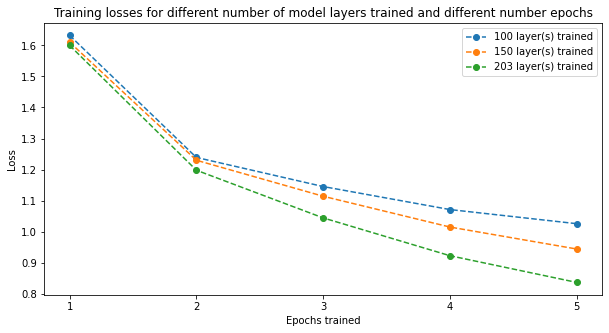

In [17]:
plot_multiple_losses(losses)

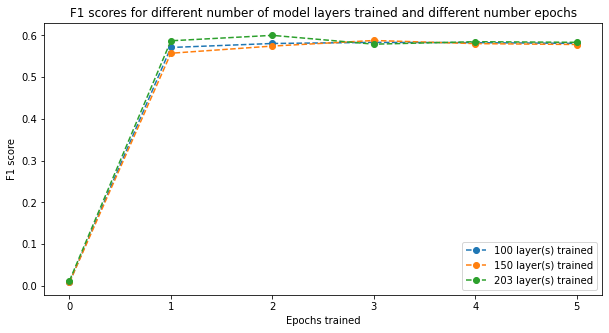

In [18]:
plot_multiple_scores(scores)

Testing model on inital samples

In [20]:
def predict_mask_tuned(tokenizer, model, model_mlm, sentences):
  for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors='pt')

    with torch.no_grad():
        temp = model.electra(**inputs)
        temp = model_mlm.generator_predictions(temp.last_hidden_state)
        logits = model_mlm.generator_lm_head(temp)
    
    mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
    predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)
    predicted_token = tokenizer.decode(predicted_token_id)
    print(f"Original sentence: '{sentence}'")
    print(f"Sentence with predicted word: '{sentence.replace('MASK', predicted_token)}'\n")

In [21]:
model.cpu()
predict_mask_tuned(tokenizer, model, model_mlm, pretrain_test_sentences)

Original sentence: 'Why don't you ask [MASK]?'
Sentence with predicted word: 'Why don't you ask [?]?'

Original sentence: 'What is [MASK]?'
Sentence with predicted word: 'What is [?]?'

Original sentence: 'Let's talk about [MASK] physics'
Sentence with predicted word: 'Let's talk about [very] physics'



In [22]:
dataset['test'][0]['best_answer']

"good communication is what does it.  Can you move beyond small talk and say what's really on your mind.  If you start doing this, my expereince is that potentially good friends will respond or shun you.  Then you know who the really good friends are."

In [23]:
predict_mask_tuned(tokenizer, model, model_mlm, [dataset['test'][0]['best_answer'].replace('mind', '[MASK]')])

Original sentence: 'good communication is what does it.  Can you move beyond small talk and say what's really on your [MASK].  If you start doing this, my expereince is that potentially good friends will respond or shun you.  Then you know who the really good friends are.'
Sentence with predicted word: 'good communication is what does it.  Can you move beyond small talk and say what's really on your [to].  If you start doing this, my expereince is that potentially good friends will respond or shun you.  Then you know who the really good friends are.'



# Results

1. After training classification model (including layers of the main electra submodel), predicted words to the sample questions drastically changed. It can be concluded that the model has forgotten how to perform the Masked LM task after learning the classification task.

2. In order to preserve the original performance of the main part of electra model on Masked LM task, the best solution is to freeze the layers of the model that are not related to the classification part. Also, enlarging train dataset sample and reducing number of training epochs could be possible solution (according to the f1 metric of the test dataset, there is a slight overfitting after the 2nd epoch).

3. During the training phase was found, that the more layers we train, the more accurate the model becomes. However, increasing number of epochs gives only negative impact on perfomance after 3rd epoch (small dataset sample size could be a reason why it happens that way).
The best weighted F1-score (about ~ 0.6) was achieved while training the whole network (203 layers) for 2 epochs.